In [120]:
import cv2
import numpy as np 
import torch 
from torchvision import transforms, models 
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision


In [121]:
resnet_model = models.resnet50(weights = True)

/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [122]:
from torchvision import transforms

In [123]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [124]:
from sklearn.cluster import KMeans

In [125]:
from sklearn.preprocessing import StandardScaler

In [126]:
print(cv2.__version__)

4.8.1


In [129]:
dataset = torchvision.datasets.Caltech101('/Users/abhinav/Desktop/CSE515-Project', download=True)
label_name_to_idx = {name: idx for idx, name in enumerate(dataset.categories)}
label_to_name = {value: key for key, value in label_name_to_idx.items()}

data_loader = torch.utils.data.DataLoader(dataset,
batch_size=4,
shuffle=True,
num_workers=8)
print(len(dataset))

Files already downloaded and verified
8677


In [130]:
label_to_name

{0: 'Faces',
 1: 'Faces_easy',
 2: 'Leopards',
 3: 'Motorbikes',
 4: 'accordion',
 5: 'airplanes',
 6: 'anchor',
 7: 'ant',
 8: 'barrel',
 9: 'bass',
 10: 'beaver',
 11: 'binocular',
 12: 'bonsai',
 13: 'brain',
 14: 'brontosaurus',
 15: 'buddha',
 16: 'butterfly',
 17: 'camera',
 18: 'cannon',
 19: 'car_side',
 20: 'ceiling_fan',
 21: 'cellphone',
 22: 'chair',
 23: 'chandelier',
 24: 'cougar_body',
 25: 'cougar_face',
 26: 'crab',
 27: 'crayfish',
 28: 'crocodile',
 29: 'crocodile_head',
 30: 'cup',
 31: 'dalmatian',
 32: 'dollar_bill',
 33: 'dolphin',
 34: 'dragonfly',
 35: 'electric_guitar',
 36: 'elephant',
 37: 'emu',
 38: 'euphonium',
 39: 'ewer',
 40: 'ferry',
 41: 'flamingo',
 42: 'flamingo_head',
 43: 'garfield',
 44: 'gerenuk',
 45: 'gramophone',
 46: 'grand_piano',
 47: 'hawksbill',
 48: 'headphone',
 49: 'hedgehog',
 50: 'helicopter',
 51: 'ibis',
 52: 'inline_skate',
 53: 'joshua_tree',
 54: 'kangaroo',
 55: 'ketch',
 56: 'lamp',
 57: 'laptop',
 58: 'llama',
 59: 'lobster

In [131]:
from skimage.io import imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt

This is ID:2
label:0


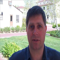

In [132]:
image_ID =2
img, label = dataset[image_ID]
print(f'This is ID:{image_ID}')
print(f'label:{label}')
newsize = (60, 60)
img = img.resize(newsize)
display(img)

In [133]:
labels_caltech_101 = np.array([dataset[i][1] for i in range(len(dataset))])


In [134]:
print(labels_caltech_101[8676])

100


In [135]:
dataset[1]

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=519x343>, 0)

In [136]:
from PIL import Image

new_dataset = []
for index, (img, label) in enumerate(dataset):
    if isinstance(img, Image.Image):  # Check if img is a PIL Image object
        img_path = img.filename  # Store the image path before closing it
        img.close()  # Close the image object
    else:
        img_path = img  # If img is already a path
    
    if index % 2 == 0:  # If it's an even-indexed image
        with Image.open(img_path) as opened_img:
            new_dataset.append((opened_img.copy(), label))  # Append a copy of the opened image to avoid closure

dataset = new_dataset

In [137]:
len(dataset)

4339

In [138]:
labels_caltech_101 = [label for index, label in enumerate(labels_caltech_101) if index % 2 == 0]


In [139]:
len(labels_caltech_101)

4339

In [140]:
from PIL import Image
from torchvision import datasets
import torch
import numpy as np
from scipy.stats import skew
import csv
from tqdm import tqdm

# Initialize an empty list to store color moments
color_moments_list = []

# Initialize an empty list to store img_arrays (if needed)
all_img_arrays = []

# Loop through the dataset
for image_ID in tqdm(range(len(dataset))):
    img, label = dataset[image_ID]
    
    # Step 1: Resize the image to 300x100
    new_size = (300, 100)
    img_resized = img.resize(new_size)
    
    # Convert the PIL Image to a NumPy array
    img_array = np.array(img_resized)
    
    #grayscale image check 
    is_gray = len(img_array.shape) == 2
    
    # Append the img_array to the list (if you need to keep all arrays)
    all_img_arrays.append(img_array)

    # Step 2: Partition the image into a 10x10 grid
    for i in range(0, 300, 30):
        for j in range(0, 100, 10):
            grid_cell = img_array[j:j+10, i:i+30]
            
            # Step 3: Calculate the color moments for each grid cell
            color_moments_dict = {}
            for color_channel, color_name in enumerate(['Gray'] if is_gray else ['Red', 'Green', 'Blue']):
                channel_data = grid_cell if is_gray else grid_cell[:, :, color_channel]

                # Calculate mean, standard deviation, and skewness
                channel_mean = np.mean(channel_data)
                channel_std = np.std(channel_data)
                if np.all(channel_data == channel_data[0]):
                    channel_skewness = 0
                else :
                    channel_skewness = skew(channel_data.reshape(-1))
                
                # Store the color moments in the dictionary
                color_moments_dict[f"{color_name}_Mean"] = channel_mean
                color_moments_dict[f"{color_name}_Std"] = channel_std
                color_moments_dict[f"{color_name}_Skewness"] = channel_skewness
            
            # Include the ImageID
            color_moments_dict["ImageID"] = image_ID
            
            # Append the color moments to the list
            color_moments_list.append(color_moments_dict)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4339/4339 [02:50<00:00, 25.48it/s]


#### Use hog_features_dict as the feature matrix

In [141]:
from torchvision import datasets
from skimage.feature import hog
from skimage.color import rgb2gray
from skimage.transform import resize
from PIL import Image
import numpy as np
from tqdm import tqdm

# Assuming you've already loaded the dataset like this:
# dataset = datasets.Caltech101('/path/to/dataset', download=True)

def extract_hog_features(image):
    # Convert PIL Image to NumPy array
    image_np = np.array(image)
    
    # Check if the image is grayscale
    if len(image_np.shape) == 2:
        gray_image = image_np
    else:
        gray_image = rgb2gray(image_np)
    
    # Resize the image
    resized_image = resize(gray_image, (300, 100))
    
    # Compute the HOG features
    features, hog_image = hog(resized_image, orientations=9, pixels_per_cell=(30, 10),
                              cells_per_block=(1, 1), visualize=True)
    
    return features, hog_image

# Initialize empty dictionaries to store features and labels
hog_features_dict = {}
hog_images_dict = {}
labels_dict = {}

# Loop over the dataset with progress bar
for i in tqdm(range(len(dataset)), desc="Extracting HOG features"):
    image, label = dataset[i]
    features, hog_image = extract_hog_features(image)
    hog_features_dict[i] = features
    hog_images_dict[i] = hog_image
    labels_dict[i] = label

# Now:
# hog_features_dict contains the 900-dimensional feature descriptor for each image, indexed by dataset index
# hog_images_dict contains the visual representation of the HOG features for each image, indexed by dataset index
# labels_dict contains the label for each image, indexed by dataset index


Extracting HOG features: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4339/4339 [00:29<00:00, 146.99it/s]


In [142]:
print(len(hog_features_dict))

4339


In [143]:
print(len(color_moments_list))

433900


In [144]:
# Resnet computations 
from torchvision import models, transforms
from PIL import Image
import torch
import numpy as np
from tqdm import tqdm

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize([0.53994344, 0.52009986, 0.49254049], 
                         [0.31415099, 0.30712622, 0.31878401]),  # Normalize the images
])

def resnet_computations(hook_layer, dataset):
    
    # List to store the output tensors for each image along with their ImageID
    outputs_with_ids = []
    skipped_images = []
    
    # List to temporarily capture the output tensor from the hook
    captured_output = [None]

    # Hook function to capture the output tensor of a specified layer
    def capture_output(module, input, output):
        captured_output[0] = output

    # Register the hook function to the specified layer
    if hook_layer == 'avgpool':
        hook = resnet_model.avgpool.register_forward_hook(capture_output)
    elif hook_layer == 'layer3':
        hook = resnet_model.layer3.register_forward_hook(capture_output)
    elif hook_layer == 'fc':   
        hook = resnet_model.fc.register_forward_hook(capture_output)

    # Loop through the dataset
    for i in tqdm(range(len(dataset))):
        try:
            img, label = dataset[i]
            #skipping grayscale images 
            if img.mode == 'L' or img.mode == '1':
                img = img.convert("RGB")

            # Apply transformations and prepare image batch
            img_tensor = transform(img)
            img_batch = img_tensor.unsqueeze(0)  # Add a batch dimension

            # Forward pass (disable gradient computation to save memory)
            with torch.no_grad():
                resnet_model(img_batch)
            
            # Retrieve the captured output tensor
            resnet_output = captured_output[0]
            if resnet_output is None:
                print("Warning: Hook Not Triggered")
                skipped_images.append(i)
                continue

            # Process the output tensor depending on the specified layer and store it in a dictionary
            output_dict = {"ImageID": i}
            if hook_layer == 'avgpool':
                avgpool_output = resnet_output.flatten().cpu().numpy()
                averaged_values = [(avgpool_output[i] + avgpool_output[i+1]) / 2.0 for i in range(0, len(avgpool_output), 2)]
                output_dict["Output"] = np.array(averaged_values)
            elif hook_layer == 'layer3':
                avg_vector = resnet_output.mean(dim=[2, 3]).cpu().numpy().squeeze()
                output_dict["Output"] = avg_vector
            elif hook_layer == 'fc':
                output_dict["Output"] = resnet_output.cpu().numpy().squeeze()
            
            # Append the dictionary to the list
            outputs_with_ids.append(output_dict)
        except Exception as e:
            print(f"Error processing ImageID {i}: {e}")
            skipped_images.append(i)
    # Remove the hook to free resources
    hook.remove()
    
    return outputs_with_ids

In [145]:
output_avgpool_with_ids = resnet_computations('avgpool',dataset)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4339/4339 [02:32<00:00, 28.46it/s]


In [146]:
print(len(output_avgpool_with_ids))

4339


In [147]:
output_layers3_with_ids = resnet_computations('layer3',dataset)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4339/4339 [02:27<00:00, 29.32it/s]


In [148]:
print(len(output_layers3_with_ids))

4339


In [149]:
output_fc_with_ids = resnet_computations('fc',dataset)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4339/4339 [02:42<00:00, 26.67it/s]


In [150]:
print(len(output_fc_with_ids))

4339


In [151]:
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans

In [ ]:
from tqdm import tqdm

In [ ]:
# import pandas as pd 
# df_color_moments = pd.read_csv("color_moments_with_imageID.csv")

In [ ]:
# print(len(df_color_moments))

In [ ]:
# feature_columns = df_color_moments.columns[1:-1]
# data_color_moments = df_color_moments[feature_columns].values

In [ ]:
# print(feature_columns)

In [ ]:
# print(data_color_moments[0]) 

In [72]:
from sklearn.decomposition import TruncatedSVD

In [ ]:
# k = 5 
# svd = TruncatedSVD(n_components = k)
# latent_semantics = svd.fit_transform(data_color_moments)
# print("Reduced Data:(Latent Semantics)")
# print(latent_semantics)

In [ ]:
def SVD_calc(feature_matrix,k):
    #print("Enter SVD calc")
    svd = TruncatedSVD(n_components=k)
    latent_semantics = svd.fit_transform(feature_matrix)
    #print("The latent semantics are:")
    print(latent_semantics)
    return latent_semantics

In [ ]:
from sklearn.decomposition import NMF 

In [ ]:
def NMF_calculator(feature_matrix,k):
    nmf = NMF(n_components=k)
    W = nmf.fit_transform(feature_matrix)
    H = nmf.components_
    return H 

In [ ]:
def LDA_calculator(feature_matrix,k):
    lda = LinearDiscriminantAnalysis(n_components = k)
    lda_result = lda.fit_transform(feature_matrix,labels_caltech_101)
    top_k_latent = lda.scalings_[:, :k]
    return top_k_latent
    

In [ ]:
def k_means_calculator(feature_matrix,k):
    kmeans = KMeans(n_clusters = k,random_state=0)
    kmeans.fit(feature_matrix)
    top_k_latent_semantics = kmeans.cluster_centers_
    return top_k_latent_semantics

## Below Is the Code Of Block of converting the Phase 1 results into feature matrices

In [ ]:
# import pandas as pd 
# df_color_moments = pd.read_csv("color_moments_with_imageID.csv")
# feature_columns = df_color_moments.columns[1:-1]
# data_color_moments = df_color_moments[feature_columns].values
# print(feature_columns)
# print(data_color_moments[0]) 

#### In the Below code block use data_color_moments as the feature matrix for SVD 
#### Use the X_color_moments for NMF and X_standardized_color_moments for remaining

In [ ]:

import pandas as pd 
color_moments_df = pd.DataFrame(color_moments_list)
color_moments_df.fillna(color_moments_df.mean(), inplace=True)
data_color_moments= color_moments_df.drop(columns="ImageID").to_numpy()
n_grids_per_image = 10 * 10  # 10x10 grid for each image
n_features_per_grid = data_color_moments.shape[1]
X_color_moments = data_color_moments.reshape(len(dataset), n_grids_per_image * n_features_per_grid)


In [ ]:
scaler_2 = StandardScaler()
X_standardized_color_moments = scaler_2.fit_transform(X_color_moments)

In [ ]:
#print(X_standardized_color_moments[0])

In [ ]:
print(len(X_color_moments))

#### Use X_hog for nmf and X_hog_standardized for remaining

In [ ]:

X_hog = np.array(list(hog_features_dict.values()))
scaler = StandardScaler()
X_hog_standardized = scaler.fit_transform(X_hog)


In [ ]:
#print(X_hog_standardized[0])

#### Feature Matrix Conversion of Resnet computations

In [ ]:
X_resnet_avgpool = np.array([entry["Output"] for entry in output_avgpool_with_ids])
X_resnet_layers3 = np.array([entry["Output"] for entry in output_layers3_with_ids])
X_resnet_fc = np.array([entry["Output"] for entry in output_fc_with_ids])


In [ ]:
print(len(X_resnet_layers3))

#### Use X_resnet_{layer_value} for NMF and X_standardized_resnet_{layer_value} for remaining reduction technique

In [ ]:
#Standardizing the data 
scaler_1 = StandardScaler()
X_standardized_resnet_avgpool = scaler_1.fit_transform(X_resnet_avgpool)
X_standardized_resnet_layers3 = scaler_1.fit_transform(X_resnet_layers3)
X_standardized_resnet_fc = scaler_1.fit_transform(X_resnet_fc)

In [ ]:
print(len(X_standardized_resnet_fc))

In [ ]:
#print(X_standardized_resnet_fc[0])

##  Create the UI here and call appropriate functions


In [ ]:
def get_feature_model_data(feature_model):
    if feature_model == "Color Moments":
        X_data = X_color_moments
        X_standardized = X_standardized_color_moments
    elif feature_model == "HOG Descriptor":
        X_data = X_hog
        X_standardized = X_hog_standardized
    elif  feature_model == "Resnet FC":
        X_data = X_resnet_fc
        X_standardized = X_standardized_resnet_fc
    elif feature_model == "Resnet Avgpool":
        X_data = X_resnet_avgpool
        X_standardized= X_standardized_resnet_avgpool 
    elif feature_model == "Resnet Layer 3":
        X_data = X_resnet_layers3
        X_standardized= X_standardized_resnet_layers3
    else:
        return -1
    return X_data,X_standardized
        

In [ ]:
def dimensionality_reduction(X_data,X_standardized,technique,k):
    if technique == 'SVD':
        #print("Entered SVD")
        result = SVD_calc(X_standardized,k)
    elif technique == 'NNMF':
        result = NMF_calculator(X_data,k)
    elif technique =='LDA':
        result = LDA_calculator(X_standardized,k)
    elif technique == 'k-means':
        result = k_means_calculator(X_standardized,k)
    else :
        return -1
    return result

In [ ]:
def main():
    #Select a Feature Model
    # Prompt user for feature model
    print("Choose a feature model:")
    print("1. Color Moments")
    print("2. HOG Descriptor")
    print("3. Resnet FC")
    print("4. Resnet Avgpool")
    print("5. Resnet Layer 3")
    feature_model_choice = input("Enter your choice(number): ")
    # Convert choice to string name
    feature_model = ["Color Moments", "HOG Descriptor", "Resnet FC", "Resnet Avgpool", "Resnet Layer 3"][int(feature_model_choice) - 1]
    #print(feature_model)
    X_data, X_standardized_data = get_feature_model_data(feature_model)
#Select the Dimensionality Reduction Technique 
    k = int(input('Please Enter the value of k'))
    # Prompt user for dimensionality reduction technique
    print("\nChoose a dimensionality reduction technique:")
    print("1. SVD")
    print("2. NNMF")
    print("3. LDA")
    print("4. k-means")
    technique_choice = input("Enter your choice: ")
    #Convert choice to specified string 
    technique = ["SVD", "NNMF", "LDA", "k-means"][int(technique_choice) - 1]
    result = dimensionality_reduction(X_data,X_standardized_data,technique,k,)
    print(f"top {k} latent-semantics of {feature_model} using {technique}")
    print(result)


In [ ]:
main()

In [ ]:
len(labels_caltech_101)

In [ ]:
print(len(hog_features_dict))

In [ ]:
len(hog_features_dict[0])

In [ ]:
print(len(color_moments_list))

In [ ]:
color_moments_list[0]

In [ ]:
print(len(output_avgpool_with_ids))

In [ ]:
len(output_avgpool_with_ids[435]['Output'])

In [ ]:
print(len(output_layers3_with_ids))

In [ ]:
print(len(output_fc_with_ids))

HOG TENSOR CREATION

In [152]:
import numpy as np

def create_empty_tensor(num_images, feature_length, num_labels):
    """
    Creates an empty tensor filled with zeros.
    """
    return np.zeros((num_images, feature_length, num_labels))

def get_label_index(label, all_labels):
    """
    Returns the index of the given label in the all_labels list.
    """
    return all_labels.index(label)

def construct_tensor(feature_vectors, labels_list, all_labels):
    num_images = len(feature_vectors)
    feature_length = len(next(iter(feature_vectors.values())))  # Length of a feature vector
    num_labels = len(all_labels)

    tensor = create_empty_tensor(num_images, feature_length, num_labels)

    for idx, feature in enumerate(feature_vectors.values()):
        # Set the feature vector in the tensor
        tensor[idx, :, :] = np.array(feature)[:, np.newaxis]

        # Set the label in the tensor
        label = labels_list[idx]
        label_index = get_label_index(label, all_labels)
        tensor[idx, :, label_index] = 1

    return tensor

    

In [153]:
hog_tensor = construct_tensor(hog_features_dict, labels_caltech_101, list(set(labels_caltech_101)))

In [ ]:
import pickle

with open("hog_tensor.pkl", "wb") as f:
    pickle.dump(hog_tensor, f, protocol=4)

In [154]:
hog_tensor.shape

(4339, 900, 101)

COLOR MOMENTS TENSOR CREATION

In [155]:
def construct_color_moments_tensor(data_list):
    num_images = len(data_list) // 100
    features_per_element = 9 # Max 9 for RGB
    elements_per_image = 100

    tensor = np.zeros((num_images, features_per_element * elements_per_image, len(set(labels_caltech_101))))

    for i in range(num_images):
        for j in range(elements_per_image):
            element = data_list[i*100 + j]
            if 'Red_Mean' in element:  # RGB features
                features = [element[key] for key in ['Red_Mean', 'Red_Std', 'Red_Skewness',
                                                     'Green_Mean', 'Green_Std', 'Green_Skewness',
                                                     'Blue_Mean', 'Blue_Std', 'Blue_Skewness']]
            else:  # Grayscale features
                features = [element[key] for key in ['Gray_Mean', 'Gray_Std', 'Gray_Skewness']]
                # Padding to match the RGB feature length
                features.extend([0] * (9 - len(features)))
            
            start_idx = j * features_per_element
            end_idx = start_idx + features_per_element
            tensor[i, start_idx:end_idx, j] = features

    return tensor

In [157]:
color_moments_tensor.shape

(4339, 900, 101)

In [156]:
color_moments_tensor = construct_color_moments_tensor(color_moments_list)

In [ ]:
import pickle

with open("color_moments_tensor.pkl", "wb") as f:
    pickle.dump(color_moments_tensor, f, protocol=4)

In [ ]:
# Print a tensor

index_to_extract = 0
extracted_tensor = color_moments_tensor[index_to_extract, :, :]

# Printing the entire 2D tensor without truncation by iterating through its rows and columns
output_data = []
for row in extracted_tensor:
    output_data.append(list(row))

# output_data

RESNET TENSOR CREATION

In [158]:
len(labels_caltech_101)

4339

In [159]:
def construct_resnet_tensor(data_list):
    num_images = len(data_list)
    feature_length = len(data_list[0]['Output'])
    
    tensor = np.zeros((num_images, feature_length, len(set(labels_caltech_101))))

    for i, element in enumerate(data_list):
        features = element['Output']
        label_index = labels_caltech_101[i]
        tensor[i, :, label_index] = features

    return tensor

In [160]:
resnet_avgpool_tensor = construct_resnet_tensor(output_avgpool_with_ids)

In [161]:
resnet_avgpool_tensor.shape

(4339, 1024, 101)

In [ ]:
with open("resnet_avgpool_tensor.pkl", "wb") as f:
    pickle.dump(resnet_avgpool_tensor, f, protocol=4)

In [162]:
resnet_layer3_tensor = construct_resnet_tensor(output_layers3_with_ids)

In [163]:
resnet_layer3_tensor.shape

(4339, 1024, 101)

In [86]:
with open("resnet_layer3_tensor.pkl", "wb") as f:
    pickle.dump(resnet_layer3_tensor, f, protocol=4)

NameError: name 'pickle' is not defined

In [164]:
resnet_fc_tensor = construct_resnet_tensor(output_fc_with_ids)

In [165]:
resnet_fc_tensor.shape

(4339, 1000, 101)

In [ ]:
with open("resnet_fc_tensor.pkl", "wb") as f:
    pickle.dump(resnet_fc_tensor, f, protocol=4)

Main function for CP decomposition

In [168]:
import tensorly as tl
from tensorly.decomposition import parafac

feature_tensor = {
    1: hog_tensor,
    2: color_moments_tensor,
    3: resnet_avgpool_tensor,
    4: resnet_layer3_tensor,
    5: resnet_fc_tensor
}

# 1: HOG
# 2: Color Moments
# 3: Resnet Avgpool
# 4: Resnet Layer3
# 5: Resnet FC

def extract_latent_semantics(tensor, k, labels):
    # Perform CP-decomposition
    weights, factors = parafac(tensor, rank=k)
    
    # Extract the weights for the label mode (assuming it's the last mode)
    label_weights = factors[2]
    
    # Sort the weights and associate with labels
    sorted_indices = label_weights.argsort(axis=0)[::-1].flatten()
    sorted_labels = [label_to_name[labels[i]] for i in sorted_indices]
    sorted_weights = label_weights[sorted_indices].flatten()
    
    # Prepare the label-weight pairs
    label_weight_pairs = list(zip(sorted_labels, sorted_weights))
    
    return label_weight_pairs

def save_to_file(label_weight_pairs, filename):
    with open(filename, 'w') as f:
        for label, weight in label_weight_pairs:
            f.write(f"{label}: {weight}\n")

def main_task_4(feature_model_id, k):
    tensor = feature_tensor[feature_model_id]
    labels = list(set(labels_caltech_101))
    
    latent_semantics = extract_latent_semantics(tensor, k, labels)
    save_to_file(latent_semantics, "latent_semantics_output.txt")
        

In [169]:
main_task_4(1,1)

In [181]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation
from sklearn.cluster import KMeans
import pandas as pd

def create_label_similarity_matrix(tensor):
    # Average across the image dimension to get label representations
    label_representations = np.mean(tensor, axis=0).T
    # Compute cosine similarities for the 900-dimensional representations
    similarities = cosine_similarity(label_representations)
 
    return similarities


def dimensionality_reduction(matrix, method, k):
    if method == "SVD":
        svd = TruncatedSVD(n_components=k)
        reduced_matrix = svd.fit_transform(matrix)
    elif method == "NNMF":
        nmf = NMF(n_components=k)
        reduced_matrix = nmf.fit_transform(matrix)
    elif method == "LDA":
        lda = LatentDirichletAllocation(n_components=k)
        reduced_matrix = lda.fit_transform(matrix)
    elif method == "k-means":
        kmeans = KMeans(n_clusters=k)
        reduced_matrix = kmeans.fit_transform(matrix)
    else:
        raise ValueError(f"Unknown method: {method}")
    return reduced_matrix

def save_to_file(matrix, filename):
    np.savetxt(filename, matrix)

def main_task_5(feature_model_id, k, reduction_method):
    tensor = feature_tensor[feature_model_id]
    similarity_matrix = create_label_similarity_matrix(tensor)
    reduced_matrix = dimensionality_reduction(similarity_matrix, reduction_method, k)
    
    # Save latent semantics
    # filename = f"latent_semantics_{reduction_method}.txt"
    # save_to_file(reduced_matrix, filename)
    
    # List label-weight pairs
    reduced_matrix = pd.DataFrame(reduced_matrix)
    reduced_matrix.index = reduced_matrix.index.map(label_to_name)
    print(pd.DataFrame(reduced_matrix))
    reduced_matrix.to_csv(f'latent_semantics_{reduction_method}.csv')
    # Compute weights for each label
    label_weights = np.sum(reduced_matrix, axis=1)

    print(label_weights)
    # Sort labels based on their weights in descending order
    sorted_indices = label_weights.argsort()[::-1]
    sorted_indices_names = [label_to_name[i] for i in label_weights.argsort()[::-1]]
    sorted_weights = label_weights[sorted_indices]
    
    # Pair the labels with their weights
    label_weight_pairs = list(zip(sorted_indices_names, sorted_weights))
    return label_weight_pairs


In [182]:
main_task_5(4, 4, "NNMF")

                      0         1         2         3
Faces          0.608837  0.000000  0.174331  0.260555
Faces_easy     0.575990  0.000000  0.194487  0.280873
Leopards       0.122503  0.031747  0.493672  0.570834
Motorbikes     0.122917  0.030626  0.493833  0.569942
accordion      0.078635  0.401943  0.377897  0.374183
...                 ...       ...       ...       ...
wheelchair     0.122500  0.031467  0.495575  0.572130
wild_cat       0.050852  0.281626  0.443387  0.470185
windsor_chair  0.122725  0.030909  0.494682  0.570506
wrench         0.141745  0.056886  0.472583  0.538265
yin_yang       0.762748  0.004963  0.071277  0.148804

[101 rows x 4 columns]
Faces            1.043722
Faces_easy       1.051350
Leopards         1.218756
Motorbikes       1.217319
accordion        1.232658
                   ...   
wheelchair       1.221673
wild_cat         1.246050
windsor_chair    1.218822
wrench           1.209479
yin_yang         0.987792
Length: 101, dtype: float64


/var/folders/06/2kgvw4c965v4sfv4w1ythkgc0000gn/T/ipykernel_31191/2111718228.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sorted_weights = label_weights[sorted_indices]


[('ant', 1.266302666457901),
 ('mayfly', 1.2660540645559129),
 ('chandelier', 1.2659276250123948),
 ('starfish', 1.2658113491822236),
 ('sea_horse', 1.265684846063221),
 ('bonsai', 1.265130869827797),
 ('crocodile_head', 1.2648987139912613),
 ('crocodile', 1.2647054074127806),
 ('pyramid', 1.2644256226390413),
 ('ketch', 1.2643486252569538),
 ('schooner', 1.2639246840223515),
 ('ferry', 1.2638100622007418),
 ('minaret', 1.262315042729306),
 ('beaver', 1.2465719570739835),
 ('platypus', 1.2465352968410786),
 ('rooster', 1.246255013220484),
 ('elephant', 1.2461566474141705),
 ('wild_cat', 1.2460498081459912),
 ('dalmatian', 1.2459348304683149),
 ('hawksbill', 1.2458557941809048),
 ('panda', 1.245734531199959),
 ('lotus', 1.2455846082155932),
 ('flamingo_head', 1.2451856359444595),
 ('cougar_face', 1.2450173308554113),
 ('water_lilly', 1.2444127261991804),
 ('hedgehog', 1.244328487108866),
 ('sunflower', 1.242073257215002),
 ('trilobite', 1.2352331013946394),
 ('pizza', 1.234509061370035)